# Charlie Chaplin Time Machine

CIFAR-10 dataset from: https://www.cs.toronto.edu/~kriz/cifar.html

In [11]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2 as cv

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

cifar = unpickle("data/cifar-10/data_batch_1")
cifar.keys()
cifar[b'data'].shape

(10000, 3072)

### Plan of attack

>##### 1) Generate cifar-10 dataset, by making all images and B&W counter parts
>##### 2) Train U-Net
>##### 3) Eval Results

#### 1) Generate BW counter parts

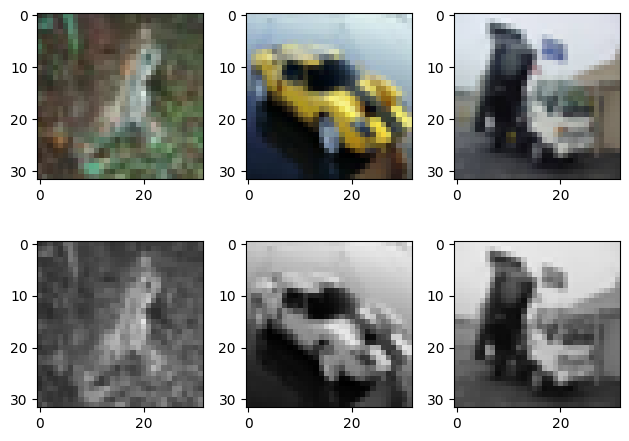

In [28]:
num_images = len(cifar[b'data'])
pixels_per_channel = int(cifar[b'data'].shape[1]/3)

cifar_imgs = np.zeros((num_images, 32, 32, 3), dtype= int)

#placing in RGB
cifar_imgs[:, :, :, 0] = cifar[b'data'][:, :pixels_per_channel].reshape(num_images, 32, 32)
cifar_imgs[:, :, :, 1] = cifar[b'data'][:, pixels_per_channel:2*pixels_per_channel].reshape(num_images, 32, 32)
cifar_imgs[:, :, :, 2] = cifar[b'data'][:, 2*pixels_per_channel:].reshape(num_images, 32, 32)

#creating GS values
#0.299 * Red + 0.587 * Green + 0.114 * Blue
cifar_imgs_gray = cifar_imgs.copy()
for i in range(3):
    cifar_imgs_gray[:, :, :, i] = 0.299 * cifar_imgs[:, :, :, 0] +  0.587 * cifar_imgs[:, :, :, 1] + 0.114 * cifar_imgs[:, :, :, 2]

#Plot a few

choice = np.random.choice(num_images, size = 3)
fig, ax = plt.subplots(2, 3)
for idx, img_id in enumerate(choice):
    ax[0, idx].imshow(cifar_imgs[img_id])
    ax[1, idx].imshow(cifar_imgs_gray[img_id])

plt.tight_layout()
plt.show()

It seems pretty challenging actually, lets see how our U-Net does

#### 2) Train U-Net

In [32]:
# Model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler, random_split
from sklearn.model_selection import train_test_split

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, ksize=3):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = ksize, stride = 1, padding = 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, ksize, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[32, 64], ksize = 3):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature, ksize = ksize))
            in_channels = feature

        # Bottleneck part
        self.bottleneck = DoubleConv(features[-1], features[-1]*2, ksize=ksize)

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature, ksize=3))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

        self.sigmoid_fraud = nn.Sigmoid()

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):

            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def identity(x): 
    return x

def train_model(X, y, use_model, config = {
    "training_split": 0.9,
    "batch_size": 10,
    "optimizer": torch.optim.AdamW,
    "learning_rate" : 1e-4,
    "loss_function": nn.CrossEntropyLoss,
    "input_transform": identity,
    "output_transform": identity,
    "prediction_transform": identity,
    "n_epochs": 50,
    "validate_every": 1 }):
    
    """
    X: training dataset of  N samples * D features - np array
    y: target for N samples - np array
    model: neural network to train torch modality - torch nn module
    
    config: training configuration, kwargs - dictionary
        contains speicifcations for: 
            - training split size : float32
            - batch_size : float32
            - optimizer : class of torch.optim
            - learning_rate : float
            - loss_function : class of loss function
            - input_transform: f(x) -> x'
            - output_transform: f(y) -> y'
            - prediction_transform: f(model(x)) -> model(x)'
            - n_epochs: int
            - validate_every : int (number of epochs)
    """

    #torch device #DEVICE = "mps" if getattr(torch, "has_mps", False) else "cuda" if torch.cuda.is_available() else "cpu"
    device = config['device']

    #Split the data
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=1-config['training_split'], shuffle=True) 

    #Create torch datasets

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    validation_dataset = TensorDataset(torch.tensor(X_validation, dtype=torch.float32), torch.tensor(y_validation, dtype=torch.float32))
    
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=torch.cuda.is_available(),
                        drop_last = False, num_workers = 2)
    validation_loader = DataLoader(validation_dataset, batch_size=config['batch_size'])

    #training configuration setup
    model = use_model.to(device=device)

    optimizer = config['optimizer'](model.parameters(),lr = config['learning_rate']) #Get optimizer
    criterion = config['loss_function']() #Get loss function

    scheduler_dict  = {'CosineAnnealing': torch.optim.lr_scheduler.CosineAnnealingLR}
    scheduler_kwargs_dict = {'CosineAnnealing': dict(T_max = n_epochs*len(train_loader.dataset))}
    scheduler = scheduler_dict["CosineAnnealing"](optimizer, **scheduler_kwargs_dict["CosineAnnealing"])

    input_transform = config['input_transform']
    labels_transform = config['labels_transform']
    prediction_transform = config['prediction_transform']

    metrics_dict = {"training": [], "validation": []}
    n_epochs = config['n_epochs'] 

    print("Training Start", 
          "\nX shape:", X_train.shape)
    for epoch in range(n_epochs):

        #Model training
        model.train()
        total_train_loss = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = (inputs.to(device=device), labels.to(device=device))
            optimizer.zero_grad()

            inputs = input_transform(inputs)
            labels = labels_transform(labels)

            prediction = model(inputs)
            loss = criterion(prediction, labels)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()
            prediction_class = prediction_transform(prediction)

        average_train_loss = total_train_loss/len(train_loader)
        metrics_dict['training'].append({"Loss": average_train_loss})

        if (epoch + 1) % config['validate_every'] == 0:
            model.eval()
            total_validation_loss = 0
            if (config['test_size'] != 0):
              for validation_inputs, validation_labels in validation_loader:
                  validation_inputs, validation_labels = (validation_inputs.to(device=device), validation_labels.to(device=device))
                  with torch.no_grad():

                      validation_inputs = input_transform(validation_inputs)
                      validation_labels = labels_transform(validation_labels)
                      
                      prediction = model(validation_inputs)
                      validation_loss = criterion(prediction, validation_labels)
                      total_validation_loss += validation_loss.item()

                      prediction_class = prediction_transform(prediction)

            average_validation_loss = total_validation_loss/len(validation_loader)
            metrics_dict['validation'].append({"Loss": average_validation_loss})

            print('Epoch:', '%03d' % (epoch + 1), 'train loss =', '{:.6f}'.format(average_train_loss),
                   'val loss =', '{:.6f}'.format(average_validation_loss))
            
    return model, metrics_dict